<a href="https://colab.research.google.com/github/crazycloud/dl-blog/blob/master/_notebooks/2020_09_20_Entity_Extraction_Transformers_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Entity Extraction (NER) - Training and Inference using Transformers - Part 2"
> Learn to train a NER model using Transformers Trainer Class, and to run Inference using Pipeline function

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [nlp, token classification, ]
- image: images/transformers-ner-part2.png
- hide: false

## Problem Statement 

In the [Part-1](http://forgetfulcrow.com/nlp/token%20classification/2020/09/19/_09_20_Entity_Extraction_Transformers_Part_1.html), we talked about how to use the pretrained language model, Tokenizer and TokenClassification model.

In this post we will train an NER model using GMB(Groningen Meaning Bank) corpus annotated dataset. The dataset is available on the [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). It has annotations for following entities

`geo` = Geographical Entity  
`org` = Organization  
`per` = Person  
`gpe` = Geopolitical Entity  
`tim` = Time indicator  
`art` = Artifact  
`eve` = Event  
`nat` = Natural Phenomenon  

The trained NER model will be able to recognize entities like in following examples

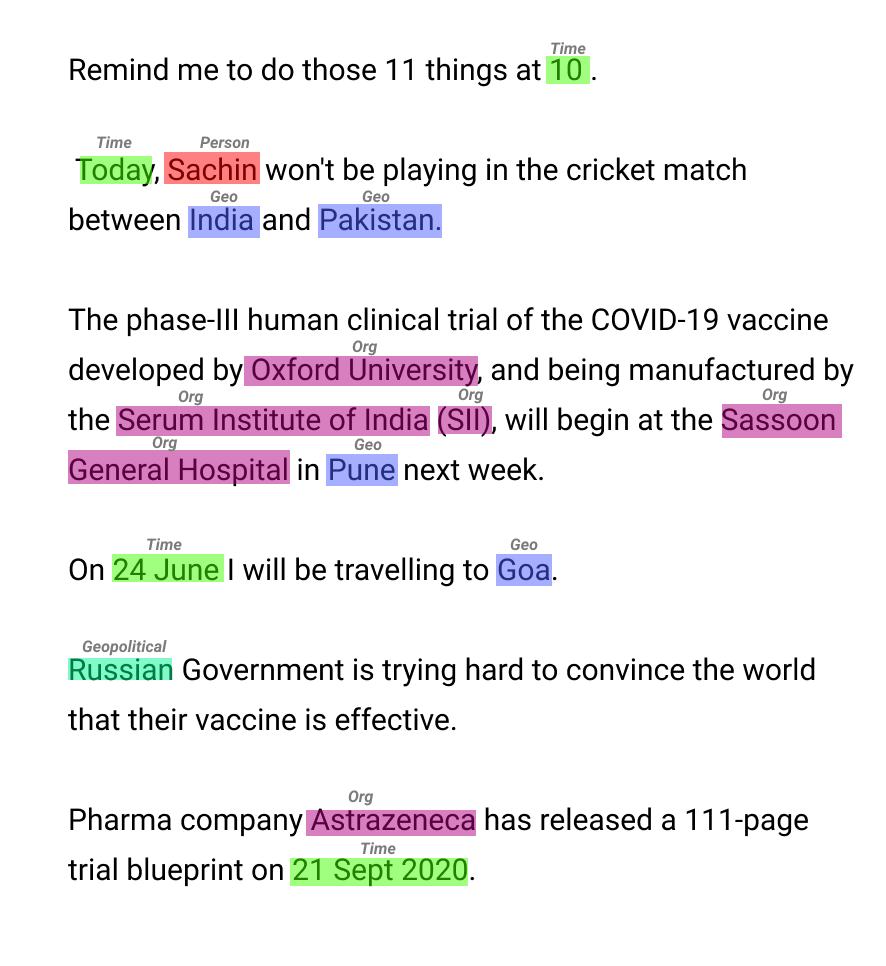

## Fine Tuning Token Classification Model

Steps for Finetuning TC Model

**Step 1.** Dataset - Get labelled dataset for training and testing. For token classification, we need word level labels like following

- `The` O  
- `battery` Aspect
- `of` O 
- `the` O  
- `speaker` O 
- `is` O 
- `very` Sentiment
- `poor` Sentiment

  
  We need train.txt, test.txt and labels.txt file to finetune the model, and to verify the performance of the model.

  train.txt/test.txt - word and corresponding label per line and a blank line between each example.

  labels.txt - list of unique tags that we have labelled in the train.txt and test.txt

**Step 2.** If the data is in any other format, we have to either convert it into this format, or write a new Task class and implement the methods of [TokenClassificationTask](https://github.com/huggingface/transformers/blob/4f6e52574248636352a746cfe6cc0b13cf3eb7f9/examples/token-classification/tasks.py#L13)

For this example, we will use the Task class NER in the [tasks.py](https://github.com/huggingface/transformers/blob/4f6e52574248636352a746cfe6cc0b13cf3eb7f9/examples/token-classification/tasks.py#L13) file. This will prepare the list of InputExample

```python
class InputExample:
    """
    A single training/test example for token classification.
    Args:
        guid: Unique id for the example.
        words: list. The words of the sequence.
        labels: (Optional) list. The labels for each word of the sequence. This should be
        specified for train and dev examples, but not for test examples.
    """
    
    guid: str
    words: List[str]
    labels: Optional[List[str]]
```

**Step 3.** NER class extends the [TokenClassificationTask](https://github.com/huggingface/transformers/blob/4f6e52574248636352a746cfe6cc0b13cf3eb7f9/examples/token-classification/utils_ner.py#L68) class which has a method `convert_examples_to_features` to convert list of example in to input features 

```python
class InputFeatures:
    """
    A single set of features of data.
    Property names are the same names as the corresponding inputs to a model.
    """

    input_ids: List[int]
    attention_mask: List[int]
    token_type_ids: Optional[List[int]] = None
    label_ids: Optional[List[int]] = None

```

This method convert_examples_to_features uses the Tokenizer class to convert InputExample into InputFeature. In the Part-1 we discussed about the Tokenizer and how to prepate input for the model.

**Step 4.** Convert InputFeatures into Pytorch Dataset. The utils_ner.py has a function to convert InputFeatures into Dataset required for training.

**Step 5.** Call the Trainer class in run_ner.py which trains the model and evaluates the model.


## Installation
Install the latest transformers library 

In [57]:
!pip install transformers==3.1.0
!pip install seqeval
!pip install conllu

     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 3.0MB 57.2MB/s 
     |████████████████████████████████| 1.2MB 60.9MB/s 
  Found existing installation: tokenizers 0.10.1
    Uninstalling tokenizers-0.10.1:
      Successfully uninstalled tokenizers-0.10.1
  Found existing installation: transformers 4.4.0.dev0
    Uninstalling transformers-4.4.0.dev0:
      Successfully uninstalled transformers-4.4.0.dev0


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the Training Data

Download the dataset from https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

download the file `new_dataset.csv`

Let's load the dataset in pandas dataframe and look at the data

In [33]:
import pandas as pd
data_path = '/content/drive/My Drive/transformers-ner/ner_dataset.csv'
df = pd.read_csv(data_path, encoding="latin-1")

# fille the empty Sentence# with the previous available value
df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [34]:
sentences = df.groupby("Sentence #")["Word"].apply(list).values
tags = df.groupby("Sentence #")["Tag"].apply(list).values

In [35]:
print(sentences[0])
print(tags[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


### Split the dataset into Train and Test using sklearn 

In [36]:
from sklearn.model_selection import train_test_split
#split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(sentences, tags, test_size=0.2, random_state=42)

In [37]:
TRAIN_FILE_PATH = '/content/drive/My Drive/transformers-ner/data/train.txt'
TEST_FILE_PATH = '/content/drive/My Drive/transformers-ner/data/test.txt'
LABELS_FILE_PATH = '/content/drive/My Drive/transformers-ner/data/labels.txt'
with open(TRAIN_FILE_PATH,'w') as ftrain:
  for (k,v) in zip(X_train, y_train):
    [ftrain.write(s+' '+t+'\n') for s,t in zip(k,v)]
    ftrain.write('\n')

with open(TEST_FILE_PATH,'w') as ftest:
  for (k,v) in zip(X_test, y_test):
    [ftest.write(s+' '+str(t)+'\n') for s,t in zip(k,v)]
    ftest.write('\n')

Prepare the labels file with list of unique labels

In [38]:
with open(LABELS_FILE_PATH,'w') as f:
  for tag in df['Tag'].unique():
    print(tag)
    f.write(str(tag)+'\n')

O
B-geo
B-gpe
B-per
I-geo
B-org
I-org
B-tim
B-art
I-art
I-per
I-gpe
I-tim
B-nat
B-eve
I-eve
I-nat


### Download Finetuning Code from Transformers Package

Download following files from transformers github repo.

In [5]:
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/utils_ner.py
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/run_ner.py
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/tasks.py



--2021-02-21 14:09:44--  https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/utils_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15629 (15K) [text/plain]
Saving to: ‘utils_ner.py’

utils_ner.py        100%[===================>]  15.26K  --.-KB/s    in 0s      

2021-02-21 14:09:44 (137 MB/s) - ‘utils_ner.py’ saved [15629/15629]

--2021-02-21 14:09:45--  https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

## Training Code


The datafiles are converted into Input Example and and input features using the tasks.py NER class. The run_ner.py takes care of converting 


>Datafile -> InputExample -> InputFeature -> Dataset -> DataLoader

which is required for Training Loop. We can simply run the run_ner.py file with all the required parameters. 

We will perform training using run_ner.py but before that let us look at how the InputExample and InputFeature looks like 

In [45]:
from tasks import NER
task = NER()

examples = task.read_examples_from_file('/content/drive/My Drive/transformers-ner/data',mode= 'train')

In [46]:
examples[:2]

[InputExample(guid='train-1', words=['South', 'Korea', "'s", 'government', 'Tuesday', 'also', 'unveiled', 'a', 'so-called', 'Green', 'New', 'Job', 'Creation', 'Plan', ',', 'expected', 'to', 'create', '9,60,000', 'new', 'jobs', '.'], labels=['B-geo', 'I-geo', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 InputExample(guid='train-2', words=['When', 'the', 'Lion', 'found', 'that', 'he', 'could', 'not', 'escape', ',', 'he', 'flew', 'upon', 'the', 'sheep', 'and', 'killed', 'them', ',', 'and', 'then', 'attacked', 'the', 'oxen', '.'], labels=['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])]

In [47]:
labels = []
for t in open(LABELS_FILE_PATH).readlines():
  labels.append(t.replace('\n',''))
labels 

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [48]:
from transformers import AutoTokenizer
tokenizer= AutoTokenizer.from_pretrained('roberta-base')

In [49]:
features = task.convert_examples_to_features(examples,label_list=labels, max_seq_length=128, tokenizer=tokenizer)

In [55]:
features[:2][0]

InputFeatures(input_ids=[3, 10050, 530, 33594, 18, 11455, 25464, 19726, 879, 548, 6691, 102, 2527, 12, 4155, 19247, 4030, 43128, 40008, 1258, 35351, 6, 10162, 560, 32845, 466, 6, 2466, 6, 151, 4651, 41207, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label_ids=[-100, 1, 4, -100, 0, 0, 7, 0, 0, -100, -100, 0, 0, -100, -100, 0, 0, 0, 

In [6]:
!python run_ner.py  --model_name_or_path 'roberta-base'\
 --labels '/content/drive/My Drive/transformers-ner/data/labels.txt' \
--data_dir '/content/drive/My Drive/transformers-ner/data' \
--output_dir 'model' \
--max_seq_length  '128' \
--num_train_epochs 3 \
--per_device_train_batch_size 8 \
--save_steps 1000000 \
--seed 16 \
--do_train \
--do_predict \
--overwrite_output_dir \
--fp16

Streaming output truncated to the last 5000 lines.
Iteration:  96% 4618/4796 [09:26<00:21,  8.09it/s]
Iteration:  96% 4619/4796 [09:26<00:21,  8.12it/s]
Iteration:  96% 4620/4796 [09:26<00:21,  8.24it/s]
Iteration:  96% 4621/4796 [09:26<00:21,  8.22it/s]
Iteration:  96% 4622/4796 [09:26<00:21,  8.22it/s]
Iteration:  96% 4623/4796 [09:27<00:20,  8.28it/s]
Iteration:  96% 4624/4796 [09:27<00:20,  8.36it/s]
Iteration:  96% 4625/4796 [09:27<00:20,  8.39it/s]
Iteration:  96% 4626/4796 [09:27<00:20,  8.32it/s]
Iteration:  96% 4627/4796 [09:27<00:20,  8.28it/s]
Iteration:  96% 4628/4796 [09:27<00:20,  8.25it/s]
Iteration:  97% 4629/4796 [09:27<00:20,  8.21it/s]
Iteration:  97% 4630/4796 [09:27<00:20,  8.22it/s]
Iteration:  97% 4631/4796 [09:27<00:20,  8.22it/s]
Iteration:  97% 4632/4796 [09:28<00:20,  8.07it/s]
Iteration:  97% 4633/4796 [09:28<00:19,  8.23it/s]
Iteration:  97% 4634/4796 [09:28<00:19,  8.31it/s]
Iteration:  97% 4635/4796 [09:28<00:19,  8.26it/s]
Iteration:  97% 4636/4796 [09:2

After training for 3 epochs the model achieves an accuracy 97% of on the test dataset

eval_loss = 0.08999748958216078  
eval_accuracy_score = 0.9735164039117754  
eval_precision = 0.8436429136279765  
eval_recall = 0.8522545712764069  
eval_f1 = 0.84792687773215  


> Tip: Reduce the per_device_train_batch_size if you are facing out of memory issues.

## Model Prediction 

Once the model is trained, the final model weights, configuration, tokenizer will be avilable in the output_dir. We will use the Pipeline module to do the model predictions.


In [ ]:
from transformers import pipeline
model_name = '/content/drive/My Drive/transformers-ner/model'
nlp = pipeline(task="ner", model=model_name, tokenizer=model_name, framework="pt",grouped_entities=True)

In [ ]:
sequence = ["Remind me to do those 11 things at 10.",
            "Today, Sachin won't be playing in the cricket match between India and Pakistan.",
            "The phase-III human clinical trial of the COVID-19 vaccine developed by Oxford University, and being manufactured by the Serum Institute of India (SII), will begin at the Sassoon General Hospital in Pune next week.",
            "On 24 June I will be travelling to Goa.",
            "Russian Government is trying hard to convince the world that their vaccine is effective.",
            "Pharma company Astrazeneca has released a 111-page trial blueprint on 21 Sept 2020."
          ]
            
result = nlp(sequence)
result

[[{'entity_group': 'B-tim', 'score': 0.5767102837562561, 'word': ' 10'}],
 [{'entity_group': 'B-tim', 'score': 0.9989056587219238, 'word': 'Today'},
  {'entity_group': 'B-per', 'score': 0.8931595087051392, 'word': ' Sachin'},
  {'entity_group': 'B-geo', 'score': 0.7804469466209412, 'word': ' India'},
  {'entity_group': 'B-geo', 'score': 0.5479587316513062, 'word': ' Pakistan'}],
 [{'entity_group': 'B-org',
   'score': 0.9265464246273041,
   'word': ' Oxford University'},
  {'entity_group': 'B-org',
   'score': 0.9648504376411438,
   'word': ' Serum Institute of India'},
  {'entity_group': 'B-org', 'score': 0.9607944488525391, 'word': 'SII'},
  {'entity_group': 'B-org',
   'score': 0.9906694442033768,
   'word': ' Sassoon General Hospital'},
  {'entity_group': 'B-geo', 'score': 0.8247686326503754, 'word': ' Pune'}],
 [{'entity_group': 'B-tim', 'score': 0.9983495771884918, 'word': ' 24 June'},
  {'entity_group': 'B-geo', 'score': 0.9488541781902313, 'word': ' Goa'}],
 [{'entity_group': '

In [ ]:
nlp = pipeline(task="ner", model=model_name, tokenizer=model_name, framework="pt",grouped_entities=False)
result = nlp(sequence)
result

[[{'entity': 'B-tim',
   'index': 10,
   'score': 0.5767102837562561,
   'word': 'Ġ10'}],
 [{'entity': 'B-tim',
   'index': 1,
   'score': 0.9989056587219238,
   'word': 'Today'},
  {'entity': 'B-per',
   'index': 3,
   'score': 0.9104933738708496,
   'word': 'ĠSach'},
  {'entity': 'I-per', 'index': 4, 'score': 0.8758256435394287, 'word': 'in'},
  {'entity': 'B-geo',
   'index': 14,
   'score': 0.7804469466209412,
   'word': 'ĠIndia'},
  {'entity': 'B-geo',
   'index': 16,
   'score': 0.5479587316513062,
   'word': 'ĠPakistan'}],
 [{'entity': 'B-org',
   'index': 17,
   'score': 0.8851138353347778,
   'word': 'ĠOxford'},
  {'entity': 'I-org',
   'index': 18,
   'score': 0.9679790139198303,
   'word': 'ĠUniversity'},
  {'entity': 'B-org',
   'index': 25,
   'score': 0.9966782331466675,
   'word': 'ĠSer'},
  {'entity': 'I-org', 'index': 26, 'score': 0.9899328947067261, 'word': 'um'},
  {'entity': 'I-org',
   'index': 27,
   'score': 0.9981464743614197,
   'word': 'ĠInstitute'},
  {'entit

We will try Training Token Classification for one more dataset in Part-3 to see how easy it is do the prediction and training for any dataset.